## Pyprob is a PyTorch-based library for probabilistic programming and inference compilation. Although it is currently a research prototype in alpha testing, there are tutorials and examples available.

* One advantage of PyProb compared to other probabilistic programming languages such as Pyro is that it allows for efficient inference using inference compilation which trains a RNN as a proposal network, and this only requires a generative model to be specified. However, Pyro requires the user explicitly define the comtrol flow for such an inference, and this is due to the fact that Pyro runs the inference network and generative model sequencially. However, Pyprob runs both of them concurrently. In addition, Pyprob allows distributed training.

* The inference engines supported are Markov chain Monte Carlo, Lightweight Metropolis Hasting (LMH), Random-walk Metropolis Hasting (RMH), Importance sampling, Regular sequential importance sampling (proposals from prior), and inference compilation. The variational inference family is not included yet.

In [1]:
!pip install pyprob

     |████████████████████████████████| 340 kB 1.5 MB/s eta 0:00:01
Processing /home/rabay/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6/termcolor-1.1.0-cp36-none-any.whl
     |████████████████████████████████| 776.7 MB 1.4 kB/s eta 0:00:011  |                                | 1.0 MB 2.5 MB/s eta 0:05:14     |█▎                              | 31.4 MB 2.3 MB/s eta 0:05:18     |██▋                             | 63.8 MB 3.4 MB/s eta 0:03:33     |███                             | 72.2 MB 2.4 MB/s eta 0:04:54     |███▎                            | 79.3 MB 332 kB/s eta 0:34:55     |███▌                            | 86.1 MB 4.7 MB/s eta 0:02:28     |████▏                           | 101.2 MB 3.6 MB/s eta 0:03:06     |█████▊                          | 138.6 MB 2.6 MB/s eta 0:04:06     |██████▌                         | 156.9 MB 4.8 MB/s eta 0:02:09     |█████████████▌                  | 327.8 MB 2.5 MB/s eta 0:03:03     |█████████████▊                  | 332.9 M

### pyprob gives access to the sample and observe statements, which explicitly denotes latent and observable variables of the program. Model is a superclass containing methods for performing inference about the program.

In [4]:
import pyprob
from pyprob import Model

### Any distributions needed for the program is imported from pyprob.distributions

In [5]:
from pyprob.distributions import Normal, Categorical

### An illustrative example is the Gaussian with unknown mean, which can be written as a probabilistic program using pyprob in the following way,
## 1.  Example of a generative model

In [8]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal

class GaussianUnknownMean(Model):
    def __init__(self):
        super().__init__(name="Gaussian with unknown mean") # give the model a name
        self.prior_mean = 1
        self.prior_std = math.sqrt(5)
        self.likelihood_std = math.sqrt(2)

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        mu = pyprob.sample(Normal(self.prior_mean, self.prior_std)) # NOTE: sample -> denotes latent variables

        # define the likelihood
        likelihood = Normal(mu, self.likelihood_std)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        pyprob.observe(likelihood, name='obs0') # NOTE: observe -> denotes observable variables
        pyprob.observe(likelihood, name='obs1')

        # return the latent quantity of interest
        return mu

model = GaussianUnknownMean()

### The task is to infer the unknown mean mu given/conditioned on the two observed variables obs0 and obs1
### Performing inference

In [11]:
# sample from posterior (5000 samples)
posterior = model.posterior_results(
                                         num_traces=5000, # the number of samples estimating the posterior
                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                                         observe={'obs0': 8, 'obs1': 9} # assign values to the observed values
                                         )

# sample mean
posterior_mean = posterior.mean
# sample standard deviation
posterior_stdd = posterior.stddev

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 5000/5000 |  41.33 | 1,782.84       


### https://modelzoo.co/model/pyprob has more than one latent variable example

## 2. SImple Gaussian (another approach to the above example)

In [15]:
import pyprob
%matplotlib inline
import matplotlib.pyplot as plt
from pyprob import Model
import numpy as np

### In pyprob, pyprob.Model and forward() method that implements the generative model should be defined first. In the body, pyprob.sample and pyprob.observe are included as keywords of a programming language.
### The below model draws random numbers a and b and draws final value from a Gaussian with mean a+b, whatever the value is with standart deviation
### the posterior p(x,z) of prior p(z)

In [29]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal

class SimpleGaussian(Model):
    def __init__(self):
        super().__init__(name="Simple Gaussian") # give the model a name
        self.prior_mean = 1
        self.prior_std = 4
        self.likelihood_std = 0.1

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        a = pyprob.sample(Normal(self.prior_mean, self.prior_std), name = 'input1') # NOTE: sample -> denotes latent variables
        b = pyprob.sample(Normal(self.prior_mean, self.prior_std), name = 'input2') # NOTE: sample -> denotes latent variables

        mu = a+b

        pyprob.observe(Normal(mu, self.likelihood_std), name='obs0') # NOTE: observe -> denotes observable variables
        return a,b

model = SimpleGaussian()

### Inference
* inferencing is efficiently getting samples that follow the posterior p(z|x).
* in the inference compilation, the model is trained, and when forward is called the appropriate distribution is sampled from such that the overall trace approaches the true posterior.

In [30]:
model.learn_inference_network(
    num_traces=10000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable obs0: reshape not specified, using shape torch.Size([]).
Observable obs0: using embedding dim torch.Size([32]).
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0: using embedding depth 3.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 20__forward__a__Normal__1, distribution: Normal
New layers, address: 44__forward__b__Normal__1, distribution: Normal
Total addresses: 2, parameters: 6,926
0d:00:00:08 | 1    | 9,920     | +5.64e+00 | +4.52e+00 | +4.87e+00 | 0d:00:00:01 | +1.00e-03 | 1,289.5                               
Stop condition reached. num_traces: 10000
0d:00:00:09 | 1    | 10,048    | +5.64e+00 | +4.52e+00 | +4.85e+00 | 0d:00:00:01 | +1.00e-03 | 1,151.9                               


### Collecting prior and posterior

In [31]:

condition  = {'obs0': 2}

prior = model.prior_results(
    num_traces=1000,
)
posterior = model.posterior_results(
    num_traces=1000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe=condition
)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 2,125.82       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 1000/1000 |  24.25 | 223.47       


### Sampling from posterior and prior

In [32]:
prior     = np.asarray([[x.item() for x in prior.sample()] for x in range(1000)])
posterior = np.asarray([[x.item() for x in posterior.sample()] for x in range(1000)])

### Below is the conditioned posterior

In [33]:
plt.scatter(prior[:,0],prior[:,1], alpha = 0.2)
plt.scatter(posterior[:,0],posterior[:,1], alpha = 0.2)
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.gcf().set_size_inches(5,5)

### the latent states a and b when conditioned on c forces the relationship to approximately hold a+b = c within std.

## 3. Breaking CAPTCHAS with probabilistic programming

In [34]:
%matplotlib inline
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

import pyprob
import pyprob.distributions
import IPython

from PIL import Image, ImageFilter, ImageDraw, ImageFont

In [35]:
# prepare the set of letters from which we 

alphabetorder = list('abcdefghijklmnopqrstuvw')
alphabet = dict(zip(range(len(alphabetorder)),alphabetorder))


def message_to_picture(width, height, message, blur):
    canvas = Image.new('L', (width, height), "white")
    font = ImageFont.load_default()
    ImageDraw.Draw(canvas).text((2,0), message, 'black', font)
    canvas = canvas.filter(ImageFilter.GaussianBlur(blur))
    d = np.asarray(list(canvas.getdata()), dtype = np.float)
    return d

def random_captcha(width, height, blur = 0.5):
    letter_distr = pyprob.distributions.Categorical([1/len(alphabet)]*len(alphabet))
    length = 3
    word =  ''.join([alphabet[letter_distr.sample().item()] for i in range(length)])
    d = message_to_picture(width, height, word,blur)
    return word, torch.tensor(d, dtype = torch.float).view(-1)/255-0.5

def likelihoood(observation,eps):
    lhood = pyprob.distributions.Normal(observation,eps*torch.ones(observation.shape))
    return lhood

In [38]:
word, img = random_captcha(20,12, blur = 0.5)
plt.imshow(img.reshape(12,20))
plt.title('ground truth: {}'.format(word))

Text(0.5, 1.0, 'ground truth: ldn')

### Integration to pyprob

In [40]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal

class CaptchaModel(Model):
    def __init__(self):
        super().__init__(name="CAPTCHA model") # give the model a name

    def forward(self): # Needed to specifcy how the generative model is run forward
        mu = pyprob.sample(pyprob.distributions.Normal(0,1))
        blur = pyprob.sample(pyprob.distributions.Normal(0.5,0.3))
        word, d = random_captcha(20,12, blur = blur)
        obs_distr = likelihoood(d,1.0)
        pyprob.observe(pyprob.distributions.Normal(d,0.5*torch.ones(d.shape)), name = 'obs0')
        return {
            'word': word,
            'image': d,
            'blur': blur
        }

model = CaptchaModel()

### unconditioned prior distribution so just integrated to pyprob just like above indeed

Time spent  | Time remain.| Progress             | Trace | ESS  | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 10/10 | 10.00 | 552.18       


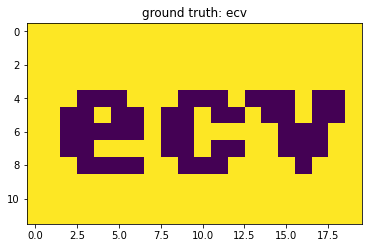

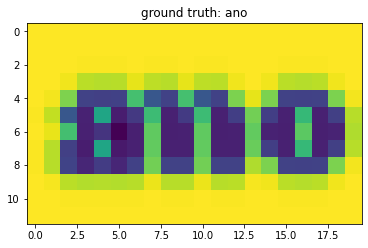

In [44]:
prior = model.prior_results()
sample = prior.sample()
plt.imshow(sample['image'].numpy().reshape(12,-1))
plt.title('ground truth: {}'.format(sample['word']))
plt.show()

sample = prior.sample()
plt.imshow(sample['image'].numpy().reshape(12,-1))
plt.title('ground truth: {}'.format(sample['word']))
plt.show()

### learning the inference network
* ML agent will be steered to get samples that match the observations (conditioning), so we can inspect latent space of the sampled traces and quickly extract solution

In [45]:
model.learn_inference_network(
    num_traces=5000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable obs0: reshape not specified, using shape torch.Size([240]).
Observable obs0: using embedding dim torch.Size([32]).
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0: using embedding depth 3.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__mu__Normal__1, distribution: Normal
New layers, address: 36__forward__blur__Normal__1, distribution: Normal
Total addresses: 2, parameters: 61,870
0d:00:00:07 | 1    | 4,928     | +1.69e+00 | +1.16e+00 | +1.17e+00 | 0d:00:00:00 | +1.00e-03 | 762.6                               
Stop condition reached. num_traces: 5000
0d:00:00:07 | 1    | 5,056     | +1.69e+00 | +1.16e+00 | +1.37e+00 | 0d:00:00:00 | +1.00e-03 | 750.1                               


### Sampling from posterior

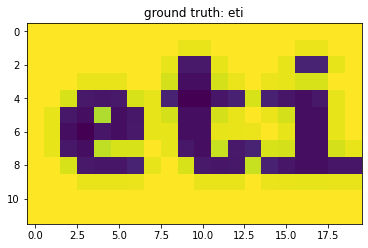

In [46]:
condition = prior.sample()
plt.imshow(condition['image'].numpy().reshape(12,-1))
plt.title('ground truth: {}'.format(condition['word']))
plt.show()

In [48]:
posterior = model.posterior_results(
    num_traces=10000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe={'obs0': condition['image'].numpy()}
)

Time spent  | Time remain.| Progress             | Trace       | ESS     | Traces/sec
0d:00:00:50 | 0d:00:00:00 | #################### | 10000/10000 |    2.20 | 198.83       


### Animations for absorving the conditioning
* 100 captchas will be drawn, and although the prior will be changing the posterior almost always yield one that looks like condition

In [49]:
for i in range(100):
    if i%10 == 0:
        print(i)
    sample = prior.sample()
    plt.imshow(sample['image'].reshape(12,-1))
    plt.title('generated {}'.format(sample['word']))
    plt.savefig('foranim_prior_{}.png'.format(str(i).zfill(6)))
plt.clf()
print('make animation')
uniq = time.time()
!convert -delay 5 -loop 0 foranim_prior_*.png prior_{uniq}.gif
!rm foranim_prior_*png
print('display image')
IPython.display.Image(url='prior_{}.gif'.format(uniq).format(uniq))

0
10
20
30
40
50
60
70
80
90
make animation
display image


<Figure size 432x288 with 0 Axes>

In [50]:

for i in range(100):
    if i%10 == 0:
        print(i)
    sample = posterior.sample()
    plt.imshow(sample['image'].reshape(12,-1))
    plt.title('ground truth: {}, generated: {}'.format(condition['word'],sample['word']))
    plt.savefig('foranim_posterior_{}.png'.format(str(i).zfill(6)))
plt.clf()
print('make animation')
uniq = time.time()
!convert -delay 5 -loop 0 foranim_posterior_*.png posterior_{uniq}.gif
!rm -rf foranim_posterior_*png
print('display image')
IPython.display.Image(url='posterior_{}.gif'.format(uniq))

0
10
20
30
40
50
60
70
80
90
make animation
display image


<Figure size 432x288 with 0 Axes>

### Inspection of latent space
* each sample drawn from the posterior full access to the trace is available.It is possible to construct marginal posterior for specific letters of the captcha

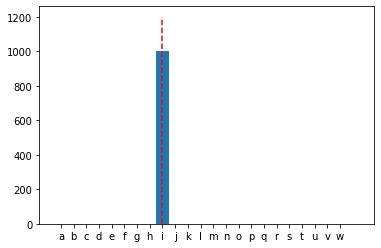

In [55]:
letter_num = 2

reverse_alphabet = {v:k for k,v in alphabet.items()} 
c,_,_ = plt.hist([reverse_alphabet[posterior.sample()['word'][letter_num]] for i in range(1000)], bins = np.linspace(-0.5,len(alphabet)+0.5,len(alphabet)+2))

plt.xticks(range(len(alphabetorder)),list(alphabetorder));
plt.vlines(reverse_alphabet[condition['word'][letter_num]],0,1.2*max(c), colors = 'r', linestyles = 'dashed')

### solving the CAPTCHA
* a solution can be the maximum a posteriori value of the posterior.
    * if we sample traces from the posterior 